## Video Generation Example

This notebooks shows how to use the results of a fully, or partially, processed experiment
to identify an "interesting" apartment to get more detailed information on like a video of just that single apartment as well as the detected cells within it (within the images that had the best focus).

### Initialization

In [3]:
%run -m celldom.nb.logging
import os
import os.path as osp
import tqdm
import numpy as np
import pandas as pd
import celldom
import glob
import matplotlib.pyplot as plt
from cvutils.visualize import display_images
from skimage import io
from skimage import draw
from celldom.core import cytometry
from celldom.execute import processing
from celldom.config import experiment_config
from celldom.nb import avutils

In [14]:
# Path to raw data -- the objective here is to reprocess 
# selected raw files (with much more detail) so we need 
# to know where to get them
raw_data_dir = osp.join(celldom.get_data_dir(), 'dataset', 'dataset03')
raw_data_dir

'/lab/data/celldom/dataset/dataset03'

In [160]:
# Ouput location of previously processed experiment
out_data_dir = osp.join(celldom.get_data_dir(), 'output', 'experiment_01')
out_data_dir

'/lab/data/celldom/output/experiment_01'

In [59]:
# Experiment configuration
exp_config_path = osp.join(
    celldom.get_repo_dir(), 'config', 
    'experiment', 'experiment_example_01.yaml'
)
exp_config = experiment_config.ExperimentConfig(celldom.read_config(exp_config_path))
exp_config_path

'/lab/repos/celldom/config/experiment/experiment_example_01.yaml'

## Find an Apartment to Explore

This section finds apartments with the most cells and then picks one to look into with more depth:

In [19]:
store = cytometry.get_readonly_datastore(out_data_dir)

In [20]:
df_apt = store.get('table_apartment')

In [37]:
# Show apartments with highest inferred cell count (ever)
df_apt.groupby(['acq_id', 'acq_cohort', 'st_num', 'apt_num'])['cell_count']\
    .max().sort_values().tail()

acq_id                            acq_cohort  st_num  apt_num
b6319ceccd1edd29b5325e8f21d7a0a2  NoDrug      000     022         96
d8d88dce09ab76432352d2fdd58aa03d  NoDrug      016     014         97
6a0bc77b73c7d29ddf37488ca255a032  NoDrug      014     020         97
cc0d7f8c30347f2404707ca5bdf2322a  NoDrug      024     016         98
debe4830c90cd285fae2dbb37bbfb73d  NoDrug      023     015        112
Name: cell_count, dtype: int64

In [50]:
# Choose one near the top
apt_num, st_num = '016', '024'

In [57]:
# Find raw files that we know will be near the chosen apartment
files = glob.glob(osp.join(
    raw_data_dir, '*NoDrug*', 'BF_ST_{}_APT_{}_*.tif'.format(st_num, apt_num)
))
print('Num files:', len(files))
files[:5]

Num files: 77


['/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_016_zm3.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_016_zm6.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_016_zm9.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_016_zp3.tif',
 '/lab/data/celldom/dataset/dataset03/2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2/BF_ST_024_APT_016_zp6.tif']

## Process Target Images

Given a judiciously selected set of raw images, reprocess those images with flags indicating that intermediate images should be saved (they're normally ignored):

In [64]:
%%time

# Import this set of flags indicating that all generated
# images should be saved (default is NO_IMAGES)
from celldom.extract import ALL_IMAGES

results = []
with cytometry.Cytometer(exp_config, '/tmp/video_experiment') as cytometer:
    for i, f in tqdm.tqdm(enumerate(files), total=len(files)):
        acq = cytometry.Acquisition(f)
        results.append(cytometer.analyze(acq, dpf=ALL_IMAGES))

Using TensorFlow backend.
100%|██████████| 77/77 [05:17<00:00,  4.12s/it]

CPU times: user 5min 45s, sys: 8min 9s, total: 13min 55s
Wall time: 5min 37s


Extract the apartment image and only relevant cell data relating to the target apartment:

In [81]:
dfv = []
for res in results:
    acq_data, apt_data, cell_data = res
    apt_data = apt_data[(apt_data['st_num'] == st_num) & (apt_data['apt_num'] == apt_num)]
    if len(apt_data) == 0:
        continue
    cell_data = cell_data[(cell_data['st_num'] == st_num) & (cell_data['apt_num'] == apt_num)]
    dfv.append((
        cell_data, 
        apt_data['apt_image'].iloc[0],
        apt_data['focus_score'].iloc[0]
    ))

Draw detected cell centroids on apartment images:

In [141]:
def assemble(cell_data, apt_image, focus_score):
    img = apt_image.copy()
    z = cell_data['acq_z'].iloc[0]
    date = cell_data['acq_datetime'].iloc[0]
    cohort = cell_data['acq_cohort'].iloc[0]
    for i, r in cell_data.iterrows():
        cx, cy = r['centroid_x'], r['centroid_y']
        rr, cc = draw.circle(cy, cx, 2, shape=img.shape)
        img[rr, cc] = np.array([255, 0, 0], dtype=np.uint8)
    return dict(
        image=img,
        focus=focus_score,
        z=z,
        date=date,
        cohort=cohort,
        cell_count=len(cell_data)
    )

dfimg = pd.DataFrame([assemble(*r) for r in dfv])
len(dfimg)

76

Select only the apartment images with the best focus:

In [146]:
dfimgb = dfimg.groupby(['date', 'cohort'])\
    .apply(lambda g: g.sort_values('focus')[['image', 'cell_count']].iloc[0])\
    .reset_index()
dfimgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
date          11 non-null datetime64[ns]
cohort        11 non-null object
image         11 non-null object
cell_count    11 non-null int64
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 432.0+ bytes


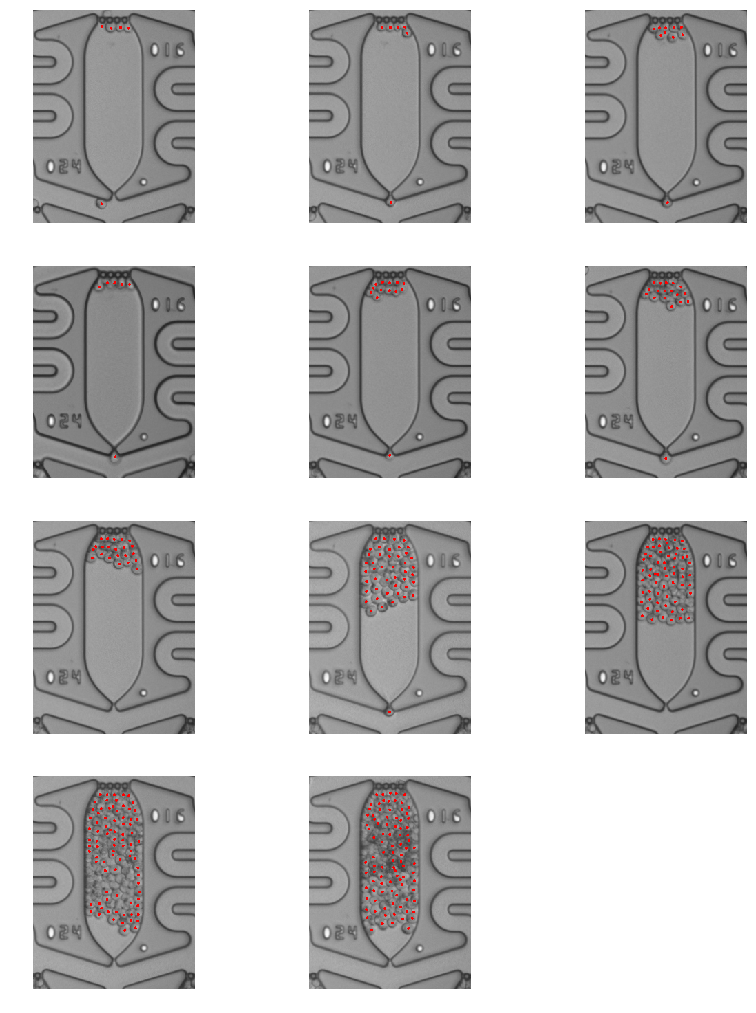

In [147]:
display_images(dfimgb['image'], cols=3)

## Results

Create a video and show some data related to it:

In [187]:
# from skimage import io as sk_io
# sk_io.imsave('results/apt024_st016.tif', np.stack(dfimgb['image'].tolist()))

In [183]:
video_path = avutils.make_video(dfimgb['image'].tolist())
video_path

'/tmp/tmp8ru9khce/video.mp4'

In [184]:
print('St Num: {}'.format(st_num))
print('Apt Num: {}'.format(apt_num))
print('Time range: {} to {}'.format(
    dfimgb['date'].min(), dfimgb['date'].max()
))
embed_video(video_path)

St Num: 024
Apt Num: 016
Time range: 2018-05-31 16:10:00 to 2018-06-04 18:20:00


In [190]:
# This video only shows up when running the notebook locally
from IPython.display import HTML
HTML(data='''
<video alt="test" controls>
<source src="https://drive.google.com/open?id=1enobdv93EuHJkFl69MaMh-6oeF5TH0mg" type="video/ogg" /></video>'''
)

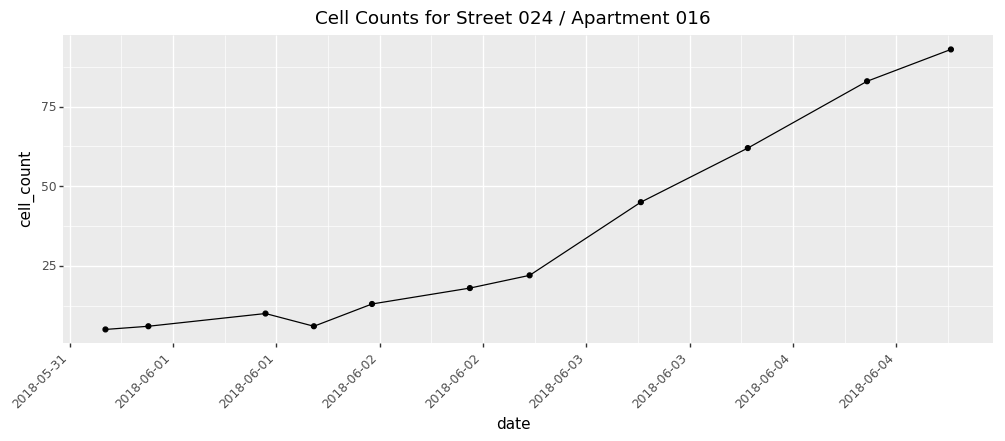

<ggplot: (-9223363242843965475)>

In [159]:
import plotnine as pn
(
    pn.ggplot(dfimgb, pn.aes(x='date', y='cell_count')) + 
    pn.geom_point() + 
    pn.geom_line() +
    pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=45, hjust=1)) +
    pn.ggtitle('Cell Counts for Street {} / Apartment {}'.format(st_num, apt_num))
)